# Support Machine Vectors (SVM)

In [37]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from time import time

def plot_decision_regions(X, y, classifier, resolution=0.02, ax=None):
    from matplotlib.colors import ListedColormap

    if ax is None:
        ax = plt.gca()

    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)

    ax.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)

    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                   alpha=0.8, color=cmap(idx),
                   marker=markers[idx], label=cl)

# Classe SVM

Di seguito la classe in python del modello

In [38]:
class SVM(object):
    """Support Vector Machine (SVM) classifier using gradient descent."""

    def __init__(self, eta=0.01, n_iter=1000, C=1.0, random_state=1, tol=1e-4, verbose=True):
        self.eta = eta              # Learning rate
        self.n_iter = n_iter        # Number of iterations
        self.C = C                  # Regularization parameter
        self.random_state = random_state
        self.tol = tol              # Tolerance for early stopping
        self.verbose = verbose      # Print iterations

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.last_cost = None

        for count in range(self.n_iter):
            cost = 0
            for xi, yi in zip(X, y):
                margin = yi * (np.dot(xi, self.w_[1:]) + self.w_[0])

                if margin >= 1:
                    self.w_ -= self.eta * self.w_  # Only regularization term
                else:
                    self.w_[1:] -= self.eta * (self.w_[1:] - self.C * yi * xi)  # Full gradient update
                    self.w_[0] -= self.eta * (-self.C * yi)

                cost += max(0, 1 - margin)  # Hinge loss

            # Memorizzo solo gli ultimi 2 costi, se la differenza tra loro due è minore 
            # del fattore `self.tol`, allora termino l'addestramento
            if self.last_cost is not None and abs(cost - self.last_cost) < self.tol:
                if self.verbose:
                    print(f"Uscita anticipata dopo {count} iterazioni")
                break
            self.last_cost = cost

        return self

    def predict(self, X):
        return np.where(np.dot(X, self.w_[1:]) + self.w_[0] >= 0, 1, -1)

Usiamo il dataset `Iris.csv`, costituito da 3 tipi di piante **IRIS**:
1. [0:50] - **Iris-setosa**
2. [50:100] - **Iris-versicolor**
3. [100:1500] - **Iris-virginica**

Da questo dataset otteniamo due tipologie di istane:

1. **Separabile Linearmente**: Iris-setosa e Iris-versicolor
2. **Non Separabile Linearmente**: Iris-versicolor e Iris-verginica

In [39]:
df = pd.read_csv("Iris.csv", encoding="utf-8")

# Istanza Separabile Linearmente

## Nota Sulla Standardizzazione

$$X_{std} = \frac{X - \mu}{\sigma} \text{ dove:}$$
1. $\mu$: è la media
2. $\sigma$: è la deviazione standard

In [40]:
y = df.iloc[:100, 5].values

# X è la matrice degli esempi e y è l'array delle label, una riga di X corrisponde ad un elemento di y
X = df.iloc[:100, [1, 3]].values
y = np.where(y == "Iris-versicolor", 1, -1)

X_std = (X - X.mean(0)) / X.std(0) # stardadizzo la matrice, così ho tutti valori sulla stessa scala

## Parametro C

$C$ è un iperparametro che possiamo usare per controllare quanto penalizzare le classificazioni errate. 
Con valori molto grandi si penalizzano maggiormente.

Accuratezza: 1.0
Secondi: 0.47191929817199707



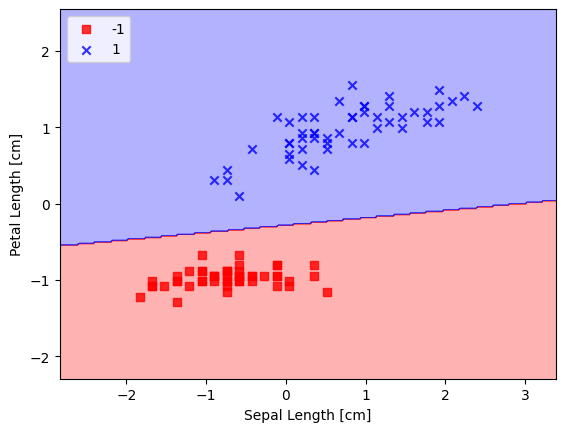

In [41]:
start_time = time()
svm_sep = SVM(eta=0.001, C=100, n_iter=1000, tol=0.01).fit(X_std, y)
end_time = time()
accuracy = np.mean(svm_sep.predict(X_std) == y)
print(f"Accuratezza: {accuracy}\nSecondi: {abs(start_time - end_time)}\n")
plot_decision_regions(X_std, y, classifier=svm_sep)

plt.xlabel('Sepal Length [cm]')
plt.ylabel('Petal Length [cm]')
plt.legend(loc='upper left')

Proviamo ora ad istanziare un insieme di modelli SVM con parametri $C$ diversi e proviamo a trovare il parametro $C$ migliore, andando a considerare l'accuratezza.

### Valore di C basso

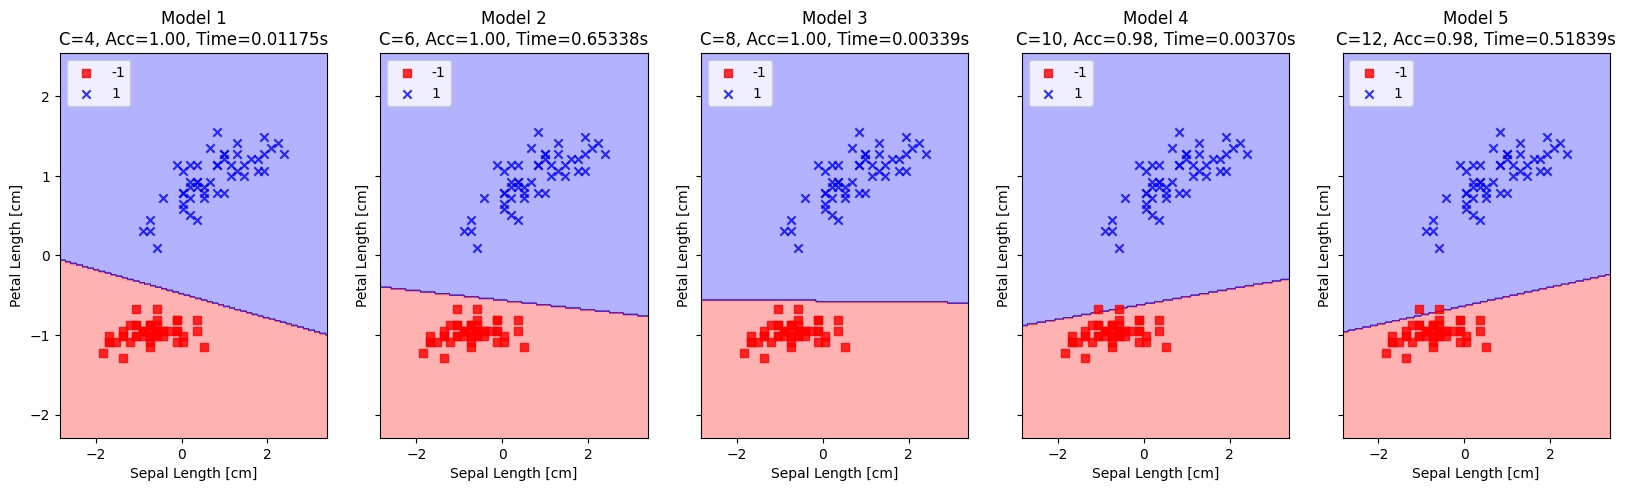

In [ ]:
n = 5
offset = 2

svms = []
times = []
accuracies = []

for x in range(n):
    C_value = (x + offset) * 2
    start_time = time()
    svm = SVM(C=C_value, eta=0.01, verbose=False, tol=0.01).fit(X_std, y)
    elapsed = time() - start_time
    acc = np.mean(svm.predict(X_std) == y)

    svms.append(svm)
    times.append(elapsed)
    accuracies.append(acc)

fig, axes = plt.subplots(1, n, figsize=(20, 5), sharex=True, sharey=True)

for idx, (svm, acc, secs) in enumerate(zip(svms, accuracies, times)):
    ax = axes[idx]
    plot_decision_regions(X_std, y, classifier=svm, ax=ax)
    ax.set_title(f"Model {idx + 1}\nC={svm.C}, Acc={acc:.2f}, Time={secs:.5f}s")
    ax.set_xlabel('Sepal Length [cm]')
    ax.set_ylabel('Petal Length [cm]')
    ax.legend(loc='upper left')

### Valore di C alto

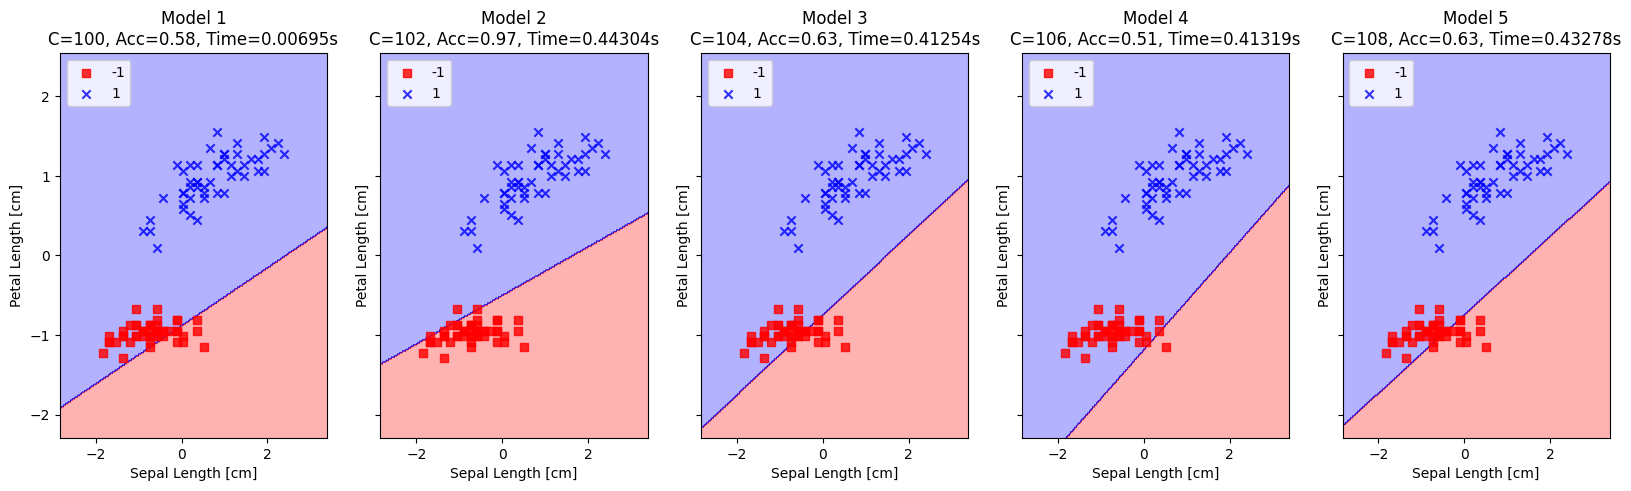

In [48]:
n = 5
offset = 50

svms = []
times = []
accuracies = []

for x in range(n):
    C_value = (x + offset) * 2
    start_time = time()
    svm = SVM(C=C_value, eta=0.01, verbose=False, tol=0.01).fit(X_std, y)
    elapsed = time() - start_time
    acc = np.mean(svm.predict(X_std) == y)

    svms.append(svm)
    times.append(elapsed)
    accuracies.append(acc)

fig, axes = plt.subplots(1, n, figsize=(20, 5), sharex=True, sharey=True)

for idx, (svm, acc, secs) in enumerate(zip(svms, accuracies, times)):
    ax = axes[idx]
    plot_decision_regions(X_std, y, classifier=svm, ax=ax)
    ax.set_title(f"Model {idx + 1}\nC={svm.C}, Acc={acc:.2f}, Time={secs:.5f}s")
    ax.set_xlabel('Sepal Length [cm]')
    ax.set_ylabel('Petal Length [cm]')
    ax.legend(loc='upper left')

# Istanza Non Separabile Linearmente

In [49]:
y = df.iloc[50:150, 5].values

# X è la matrice degli esempi e y è l'array delle label, una riga di X corrisponde ad un elemento di y
X = df.iloc[50:150, [1, 3]].values
y = np.where(y == "Iris-versicolor", 1, -1)

X_std = (X - X.mean(0)) / X.std(0) # stardadizzo la matrice, così ho tutti valori sulla stessa scala

Uscita anticipata dopo 7 iterazioni
Accuratezza: 0.9
Secondi: 0.013181924819946289



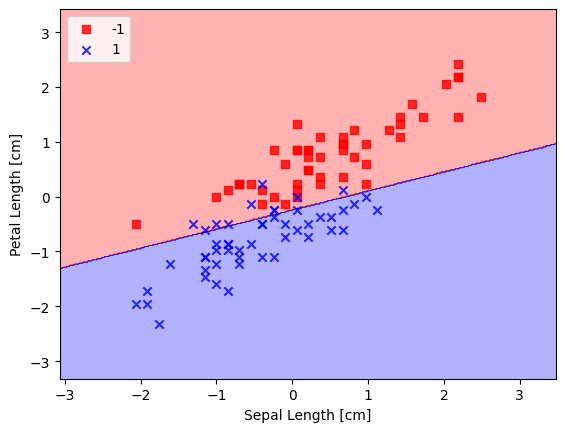

In [50]:
start_time = time()
svm_sep = SVM(eta=0.001, C=100, n_iter=1000, tol=0.01).fit(X_std, y)
end_time = time()
accuracy = np.mean(svm_sep.predict(X_std) == y)
print(f"Accuratezza: {accuracy}\nSecondi: {abs(start_time - end_time)}\n")
plot_decision_regions(X_std, y, classifier=svm_sep)

plt.xlabel('Sepal Length [cm]')
plt.ylabel('Petal Length [cm]')
plt.legend(loc='upper left')

### Valore di C basso

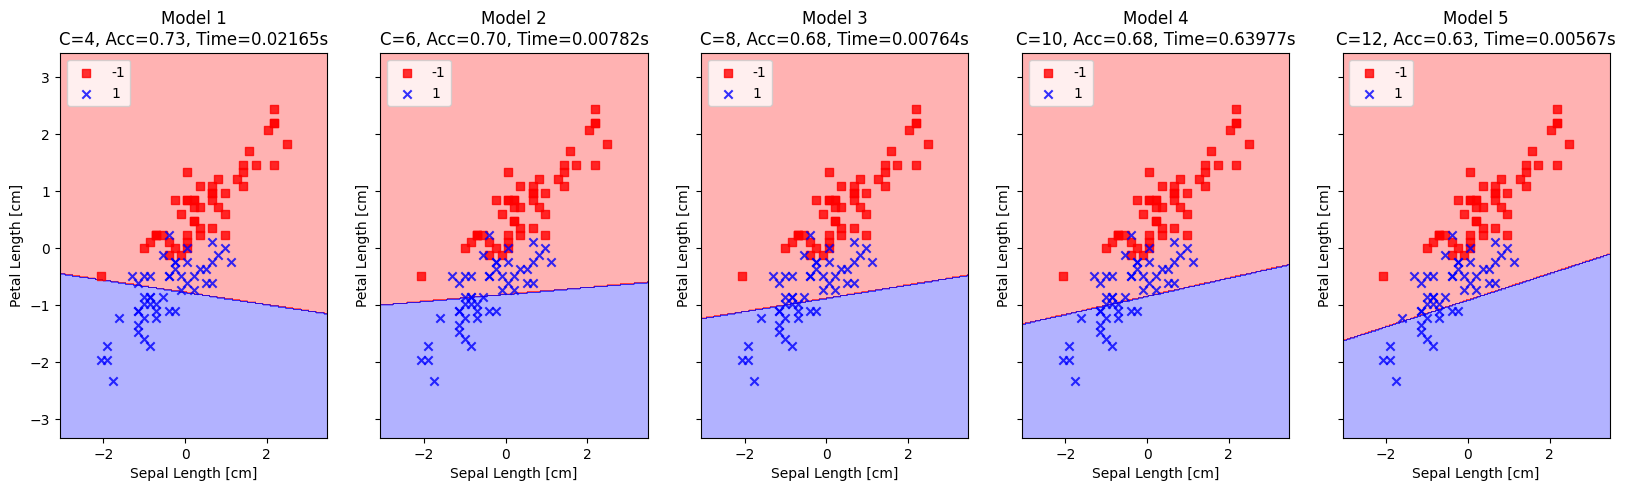

In [51]:
n = 5
offset = 2

svms = []
times = []
accuracies = []

for x in range(n):
    C_value = (x + offset) * 2
    start_time = time()
    svm = SVM(C=C_value, eta=0.01, verbose=False, tol=0.01).fit(X_std, y)
    elapsed = time() - start_time
    acc = np.mean(svm.predict(X_std) == y)

    svms.append(svm)
    times.append(elapsed)
    accuracies.append(acc)

fig, axes = plt.subplots(1, n, figsize=(20, 5), sharex=True, sharey=True)

for idx, (svm, acc, secs) in enumerate(zip(svms, accuracies, times)):
    ax = axes[idx]
    plot_decision_regions(X_std, y, classifier=svm, ax=ax)
    ax.set_title(f"Model {idx + 1}\nC={svm.C}, Acc={acc:.2f}, Time={secs:.5f}s")
    ax.set_xlabel('Sepal Length [cm]')
    ax.set_ylabel('Petal Length [cm]')
    ax.legend(loc='upper left')

### Valore di C alto

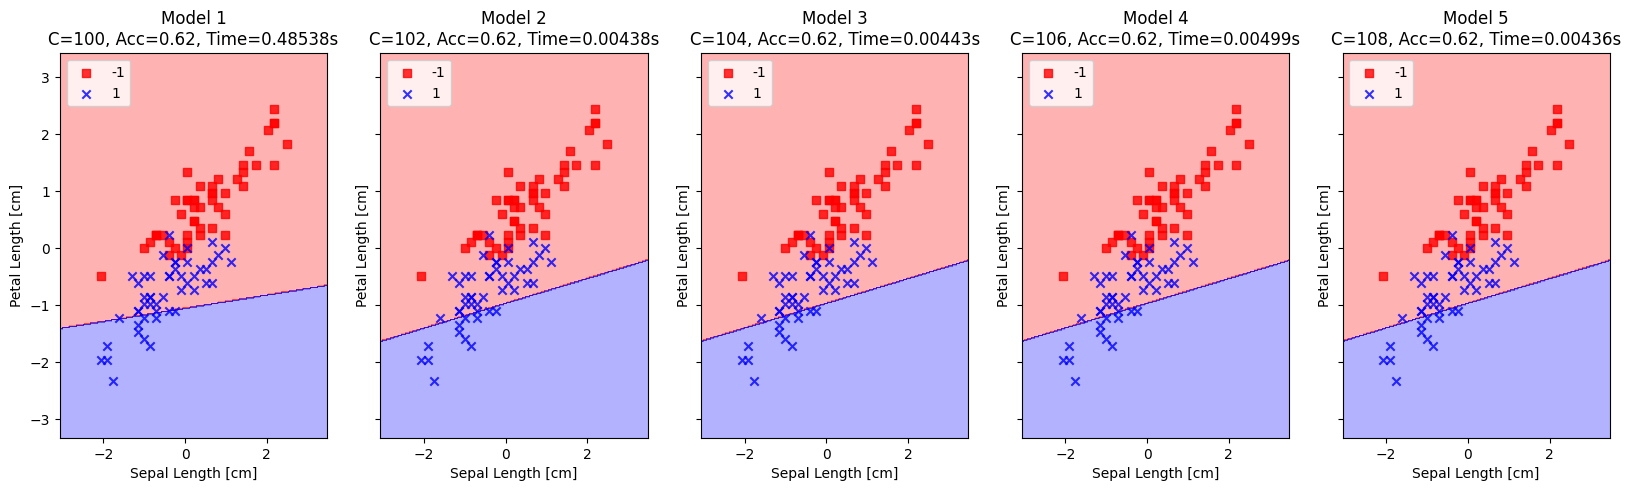

In [52]:
n = 5
offset = 50

svms = []
times = []
accuracies = []

for x in range(n):
    C_value = (x + offset) * 2
    start_time = time()
    svm = SVM(C=C_value, eta=0.01, verbose=False, tol=0.01).fit(X_std, y)
    elapsed = time() - start_time
    acc = np.mean(svm.predict(X_std) == y)

    svms.append(svm)
    times.append(elapsed)
    accuracies.append(acc)

fig, axes = plt.subplots(1, n, figsize=(20, 5), sharex=True, sharey=True)

for idx, (svm, acc, secs) in enumerate(zip(svms, accuracies, times)):
    ax = axes[idx]
    plot_decision_regions(X_std, y, classifier=svm, ax=ax)
    ax.set_title(f"Model {idx + 1}\nC={svm.C}, Acc={acc:.2f}, Time={secs:.5f}s")
    ax.set_xlabel('Sepal Length [cm]')
    ax.set_ylabel('Petal Length [cm]')
    ax.legend(loc='upper left')

Diminunendo poi $\eta$ a $0.001$ riusciamo a creare dei modelli con un'accuracy più elevato